# Interpolation
___

**Remarks**
- Code will need to be modified a bit to reflect the use of a certain group of data instead of all data

In [1]:
import numpy as np
import pandas as pd
import os
import pickle

import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from itertools import combinations

# from scipy.spatial.distance import pdist
# from scipy.stats import chisquare, chi2
from scipy.stats import ttest_1samp, t

from pykrige.ok import OrdinaryKriging
from pykrige.rk import Krige
import pykrige.kriging_tools as kt

from sklearn.model_selection import cross_val_predict

from joblib import Parallel, delayed
import multiprocessing

In [2]:
import prepostprocessing.pre_processing as preproc
import prepostprocessing.post_processing as postproc
import nugget_estimation.kriging_tools as krigingtools
import nugget_estimation.detrending as detrending
import plots.plots as plots
import prepostprocessing.cleaning as cleaning
import cross_validation.leave_one_out_cross_validation as loocv

import qapf.qapf as qapf
import statistics.ttest as ttest
import statistics.simulations as sim

import toolbox.toolbox as tb

In [3]:
# Load jupyter extension to reload packages before executing user code.
# https://ipython.readtheMLcs.io/en/stable/config/extensions/autoreload.html
%load_ext autoreload
# Reload all packages (except those excluded by %aimport) every time before executing the Python code typed.
%autoreload 2

In [8]:
# You only need to run this cell once if you want to have multiple outputs in all your notebooks.
# It is a general setting so you can set this cell's status to 'raw'
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [9]:
coordinates_latlon = preproc.load_obj("coordinates_area4")
coordinates_utm = preproc.load_obj("coordinates_utm_area4")
mineralogy = preproc.load_obj("mineralogy_area4")
mineralogy_clr = preproc.load_obj("mineralogy_clr_area4")
mineralogy_pca = preproc.load_obj("mineralogy_pca_area4")
mineralogy_pca_df = preproc.load_obj("mineralogy_pca_area4_df")
metadata = preproc.load_obj("metadata_area4")

## EDA
___

In [10]:
# Get number of control points that will be used
number_of_control_points = coordinates_utm.shape[0]
number_of_control_points

476

In [11]:
coordinates_utm

,Y_UTM,X_UTM,ZoneNumber,ZoneLetter
5,7.165453e+05,7.654590e+06,57,V
21,1.317109e+06,7.163468e+06,57,V
29,1.291319e+06,7.013925e+06,57,V
53,1.257902e+06,7.650810e+06,57,V
62,1.365606e+06,7.599095e+06,57,V
...,...,...,...,...
4635,8.124596e+05,7.045757e+06,57,V
4639,7.921554e+05,7.112601e+06,57,V
4651,6.209919e+05,7.621993e+06,57,V
4655,7.373749e+05,7.408189e+06,57,V


In [12]:
coordinates_utm = coordinates_utm.rename({"X_UTM": "Y", "Y_UTM": "X"}, axis=1)

In [13]:
# FILL IN SHORT NAME HERE THAT WILL BE USED WHEN SAVING THE PLOT (e.g. "G1")
group_name = "area4"

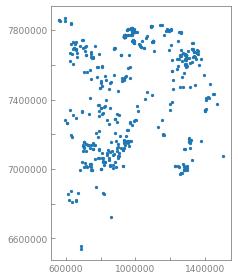

In [14]:
# Plot control points with labels
plots.plot_map_with_control_points(coordinates_utm, group_name, label_size=4, subset=["X", "Y"],
                                   show_labels=False,
                                  skip_xaxis_label=2, skip_yaxis_label=2, 
                                  skip_xaxis_start=1, skip_yaxis_start=1)

In [15]:
# Show unique zone letters and zone numbers of utm coordinates
coordinates_utm["ZoneNumber"].unique()
coordinates_utm["ZoneLetter"].unique()

array([57], dtype=int64)

array(['V'], dtype=object)

In [16]:
# Calculate minimum and maxmin lag distance between two points of the dataset
distance_matrix = krigingtools.calculate_and_sort_square_distance_matrix(coordinates_utm[["X", "Y"]])

min_lag_distance = np.amin(distance_matrix)
max_lag_distance = np.amax(distance_matrix)
min_lag_distance, max_lag_distance

(0.15264244709525393, 1375679.1827018806)

(array([ 4252.,  6522.,  5840.,  6780.,  7086.,  7590.,  8246.,  8770.,
         9118., 10180., 11332.,  9168.,  8398.,  9232.,  9806.,  9536.,
        10214., 11492., 11710., 10616., 10076.,  9002.,  7890.,  7080.,
         5592.,  2622.,  1914.,  1204.,  1050.,  1072.,   750.,   516.,
          474.,   184.,    66.,   154.,   274.,   138.,    78.,    76.]),
 array([1.52642447e-01, 3.43921284e+04, 6.87841041e+04, 1.03176080e+05,
        1.37568056e+05, 1.71960031e+05, 2.06352007e+05, 2.40743983e+05,
        2.75135959e+05, 3.09527934e+05, 3.43919910e+05, 3.78311886e+05,
        4.12703862e+05, 4.47095837e+05, 4.81487813e+05, 5.15879789e+05,
        5.50271765e+05, 5.84663740e+05, 6.19055716e+05, 6.53447692e+05,
        6.87839668e+05, 7.22231643e+05, 7.56623619e+05, 7.91015595e+05,
        8.25407571e+05, 8.59799546e+05, 8.94191522e+05, 9.28583498e+05,
        9.62975474e+05, 9.97367449e+05, 1.03175943e+06, 1.06615140e+06,
        1.10054338e+06, 1.13493535e+06, 1.16932733e+06, 1.2037

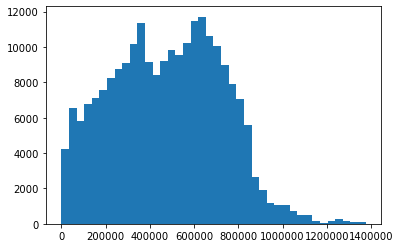

In [17]:
plt.hist(distance_matrix.flatten(), bins=40)

In [18]:
np.where(distance_matrix == 0)

(array([], dtype=int64), array([], dtype=int64))

## Critical distance estimation
___

In [19]:
# Range (lag distance at which the sill is reached; in meters)

# Depending on how many principal components you will use, 
# you will have to add more entries to this list.

# Modified the range since variograms are not correct yet
# range_ = [100000] * 15
range_ = [120000, 120000, 120000, 120000, 120000, 120000, 120000, 120000, 120000, 100000, 100000, 100000, 100000, 100000, 100000]



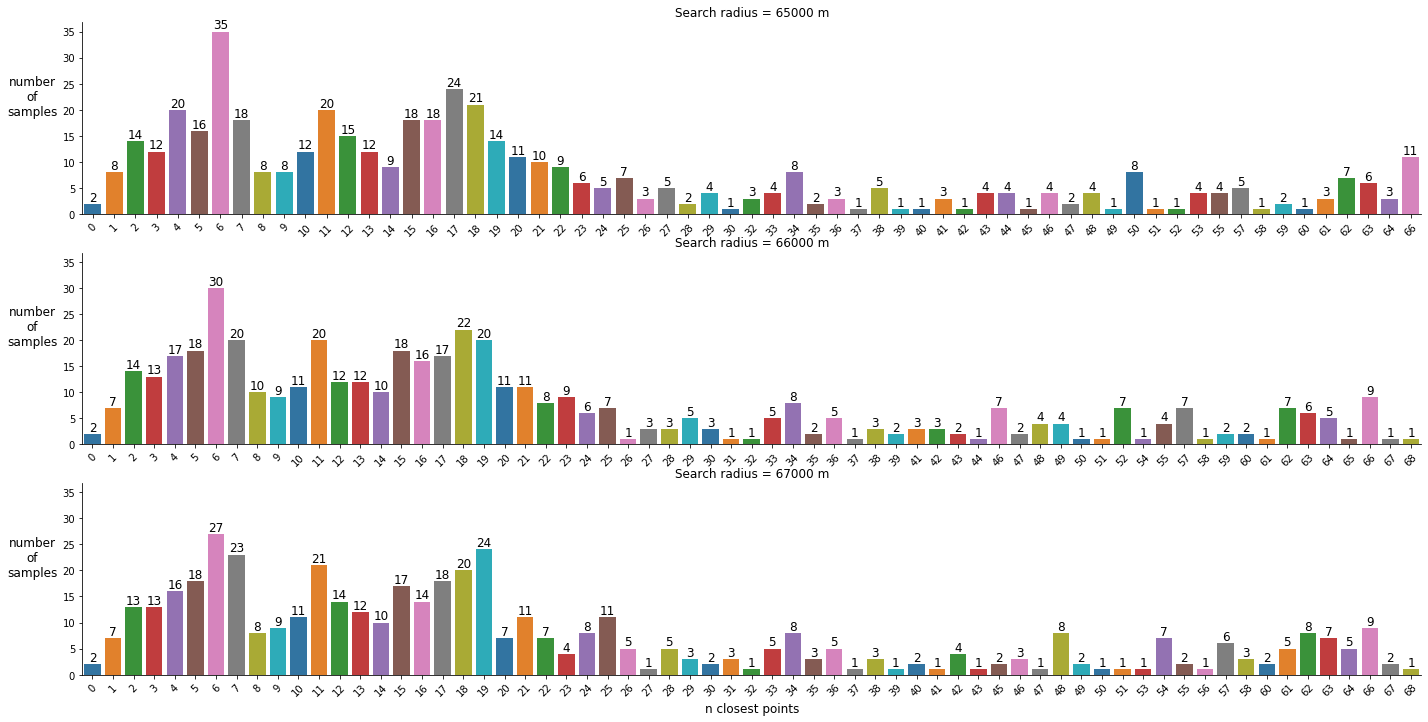

In [20]:
# You can adjust the radius parameters below to change the slider settings
# to visualize the figures interactively
plots.interactive_plot_search_radius(coordinates_utm, orient='rows', 
                                     radius_default=66000, # Default slider position
                                     radius_min=30000,  # Slider start
                                     radius_max=66000, # Slider stop
                                     radius_step=1000,  # Slider step
                                     radius_offset=1000) # Offset between visualizations shown

# The x-axis stands for 'n_neighbours'

In [21]:
# Critical distance (in meters)
# This is the distance where at least 95% of your samples
# will have at least 3 neighbours within that distance

# You can refine this value later on, or we can use the range 
# instead of the critical distance as the only value for the search radius
critical_distance = 65000

In [22]:
# This is basically creating a list of how many neighbours each data point has 
# within the critical_distance and within the range
nvalues_control_points = {}

for radius in (0.05, critical_distance, range_[0]):
    temp = krigingtools.find_points_within_search_radius(
               krigingtools.calculate_and_sort_square_distance_matrix(coordinates_utm),
               search_radius=radius # 'search_radius' should be equal to 'radius' here, not 'critical_distance'
           )
    nvalues_control_points[radius] = pd.Series(temp, index=coordinates_utm.index)
    
# You're performing a calculation in a for loop so we want to check how many neighbours each data point has 
# within the specified radius in the tuple (0.05, critical_distance, range_[0]). 
# So for each of these specified distances, the function will be executed and 
# the result stored in the nvalues_control_points dictionary

In [23]:
# Number of samples that may still have less than 3 neighbours within the critical distance
number_of_control_points * 0.05

23.8

In [24]:
# Check number of samples outside of critical distance
samples_outside_critical_distance = nvalues_control_points[critical_distance][nvalues_control_points[critical_distance] < 3].index.tolist()
len(samples_outside_critical_distance)

# 0.2 sample above 23.8

24

In [25]:
# Overview of samples that are outside search_radius
mineralogy_pca_df.loc[samples_outside_critical_distance, :]

,PC01,PC02,PC03,PC04,PC05,PC06,PC07,PC08,PC09,PC10,PC11,PC12,PC13
72,1.435925,-2.474373,-0.937018,2.074586,-1.469121,1.427248,-0.595525,-0.098147,-1.098230,0.619902,0.073581,0.015204,3.393978e-16
331,1.276068,-0.309628,0.068989,-2.565075,-2.041723,-0.476596,0.400943,-0.520928,0.542499,0.300499,-0.010166,-0.112064,7.238938e-17
429,1.358176,1.454216,2.439906,0.344045,-1.133745,0.934229,0.374244,-0.579195,1.375038,-0.211419,0.014323,-0.109939,4.691669e-16
624,0.731493,-1.754188,-0.504987,1.746849,0.163568,0.662089,-1.111581,0.052112,1.654226,-0.519603,0.099755,0.070141,5.045263e-16
1118,2.321242,1.390890,-0.948785,0.398148,0.927158,2.180653,0.543242,-0.500371,0.571758,-0.147052,0.001654,-0.067744,6.455197e-16
1185,0.300576,-1.376918,0.415120,1.596484,-0.040505,-0.091327,-0.238531,-0.257247,-0.702155,0.095648,0.362578,0.111279,3.458467e-16
1351,3.815250,0.876159,1.543484,-1.231788,0.003336,-0.101559,0.127789,0.099211,0.363709,0.537246,0.104381,0.048111,3.242627e-16
1541,0.561956,-1.667727,0.147224,0.786323,-0.208505,0.367480,-0.339233,-0.070832,0.320706,-0.175941,-0.048183,0.078089,3.456676e-16
2141,0.836675,-2.135053,0.981514,0.927322,0.631790,0.608955,-0.156219,-0.174746,-0.205839,-0.048811,-0.154091,0.066648,3.034525e-16
2731,-0.717849,-0.262646,-0.934237,0.157703,0.461045,-0.213061,0.115638,0.121054,0.059500,-0.238677,-0.104875,-0.072656,5.210691e-16


____

In [26]:
# Create dataframe with duplicates grouping and count info
# https://stackoverflow.com/questions/53760860/pd-duplicated-groups-of-duplicates
cols = ["X", "Y"]
df1 = coordinates_utm[coordinates_utm.duplicated(subset=cols, keep=False)].copy()
df1 = df1.sort_values(cols)
df1['group'] = 'g' + (df1.groupby(cols).ngroup() + 1).astype(str)
# df1['group'] = 'g' + f"{df1['group'].str()[1:]:02d}"
df1['duplicate_count'] = df1.groupby(cols)['X'].transform('size')

In [27]:
df1.sort_index().sort_values(by="duplicate_count", ascending=False)

,X,Y,ZoneNumber,ZoneLetter,group,duplicate_count


In [28]:
# Get list of duplicate groups which hold list of corresponding items
group_items = df1.groupby("group").apply(lambda x: x.index.tolist())
group_items

""
group


In [29]:
group_items_df = pd.DataFrame(group_items)

In [30]:
# Create dictionary of droup items for easy reference
group_items_dict = {k:v for (k, v) in zip(group_items.index, group_items.values)}

In [31]:
for group, items in group_items_dict.items():
    print(group)
    coordinates_latlon.loc[items, :]

In [32]:
for group, items in group_items_dict.items():
    print(group)
    metadata.loc[items, :]

In [33]:
for group, items in group_items_dict.items():
    print(group)
    mineralogy.loc[items, :]

In [34]:
# Check to see how many points are on a shared location
nvalues_control_points[0.05].sum()

# 0 on shared location 

0

___

## Create high resolution grids
____

In [35]:
# Determine (wide) grid boundaries
X = coordinates_utm.iloc[:, 0].values
Xmin = np.min(X) - critical_distance * 1.05
Xmax = np.max(X) + critical_distance * 1.05

Y = coordinates_utm.iloc[:, 1].values
Ymin = np.min(Y) - critical_distance * 1.05, 
Ymax = np.max(Y) + critical_distance * 1.05

coordinates_boundaries = np.array([[Xmin, Xmax], [Ymin, Ymax]])
coordinates_boundaries

array([[492917.5031534544, 1572554.851634499],
       [(6472629.465764278,), 7938294.718777128]], dtype=object)

In [36]:
# Set approximate number of points along each axis
n_points = 300

temp = {}
x, y = coordinates_boundaries

temp["x_start (m)"] = int(np.floor(x[0]))
temp["x_end (m)"] = int(np.floor(x[1]))
temp["y_start (m)"] = int(np.floor(y[0]))
temp["y_end (m)"] = int(np.floor(y[1]))

print("x", x)
print("y", y)

temp["x_range (m)"] = int(np.floor(x[1])) - int(np.floor(x[0]))
temp["y_range (m)"] = int(np.floor(y[1])) - int(np.floor(y[0]))
print("x range: ", temp["x_range (m)"])
print("y range: ", temp["y_range (m)"])

ranges = {"x": temp["x_range (m)"],
          "y": temp["y_range (m)"],
         }

threshold = 10000000
for dimension, ranger in ranges.items():
    if ranger < threshold:
        smallest_dimension = dimension
        threshold = ranger
print("smallest dimension", smallest_dimension)

x_spacing, dx = np.linspace(x[0], x[1], n_points, retstep=True)
y_spacing, dy = np.linspace(y[0], y[1], n_points, retstep=True)

steps = {"x": dx,
         "y": dy,
        }

print("theoretical x spacing: ", dx)

xgrid = np.arange(x[0]-dx, x[1]+dx, steps[smallest_dimension])
ygrid = np.arange(y[0]-dy, y[1]+dy, steps[smallest_dimension])

print("actual x spacing: ", xgrid[1] - xgrid[0])
print("actual y spacing: ", ygrid[1] - ygrid[0])

temp["x_spacing (m)"] = np.round(xgrid[1] - xgrid[0], 2)
temp["y_spacing (m)"] = np.round(ygrid[1] - ygrid[0], 2)

print("Number of points: ", len(xgrid) * len(ygrid))
print("xy grid: ", len(xgrid), len(ygrid), "\n")

temp["#xgrid_points"] = len(xgrid)
temp["#ygrid_points"] = len(ygrid)
temp["#total_grid_nodes"] = len(xgrid) * len(ygrid)

coordinates_grids = [xgrid, ygrid]
coordinates_grids_details = temp

# Assigned to a different variable (name) because later on 'grid' gets used in the code
grid = coordinates_grids

x [492917.5031534544 1572554.851634499]
y [(6472629.465764278,) 7938294.718777128]
x range:  1079637
y range:  1465665
smallest dimension x
theoretical x spacing:  3610.8272524449653
actual x spacing:  3610.827252444986
actual y spacing:  3610.827252444811
Number of points:  123109
xy grid:  301 409 



## Classification map
___

We will have to decide on a certain classification scheme before we could use this.  
Another option might be to use a condensed version of the 'type_granite' column.

**Yep**

## Detrending
____

In [37]:
# Check if there is a trend present in the data
# This is the case if R² is above say 0.70 

for component in mineralogy_pca_df.columns.tolist()[:-1]:
    for order in [1, 2]:
        print("R² for", component, "order =", order, ":")
        detrending.detrend(coordinates_utm, 
                           mineralogy_pca_df[component], 
                           order=order, 
                           verbose=False, 
                           plot_points=False)[1]

R² for PC01 order = 1 :


0.20659262625320773

R² for PC01 order = 2 :


0.22144589711873952

R² for PC02 order = 1 :


0.04182176345174027

R² for PC02 order = 2 :


0.07337588340198253

R² for PC03 order = 1 :


0.04295191685157851

R² for PC03 order = 2 :


0.05018579677967161

R² for PC04 order = 1 :


0.11214137671277702

R² for PC04 order = 2 :


0.12609321259549622

R² for PC05 order = 1 :


0.0760057382077608

R² for PC05 order = 2 :


0.10263475955763668

R² for PC06 order = 1 :


0.038448617046358935

R² for PC06 order = 2 :


0.08375495622271245

R² for PC07 order = 1 :


0.02172353022208795

R² for PC07 order = 2 :


0.06198485803831555

R² for PC08 order = 1 :


0.021056525898750844

R² for PC08 order = 2 :


0.03345503810908279

R² for PC09 order = 1 :


0.04787917254848795

R² for PC09 order = 2 :


0.07353409539100741

R² for PC10 order = 1 :


0.005007297423074264

R² for PC10 order = 2 :


0.008076308285993372

R² for PC11 order = 1 :


0.04443826261618122

R² for PC11 order = 2 :


0.07459130516644474

R² for PC12 order = 1 :


0.015859926241124533

R² for PC12 order = 2 :


0.04560295633291522

## Variogram modelling
___

* Variogram model (str)
* Sill (float)
* Range (float)
* Nugget (float)
* Number of lag bins (int)
* Weighted (Bool)

In [38]:
# Nugget (variance at lag=0 metric)

# Since we are not dealing with point count data here,
# we can not use the formulas from our paper we have talked about
# Therefore I would just start with nugget=0 and perhaps later change this

# Depending on how many principal components you will use, 
# you will have to add more entries to this list.
nugget_ = [0.875, 0.792, 0.411, 0.428, 0.343, 0.260, 0.204, 0.0963, 0.0976, 0., 0., 0., 0., 0., 0.]

In [39]:
PC_nr_list = [nr[2:] for nr in mineralogy_pca_df.columns]
PC_nr_list

['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13']

In [40]:
# Sill (total variance metric)

# A 'list comprehension' construction is used here
sill_ = [mineralogy_pca_df.loc[:, f"PC{i}"].values.var(ddof=1) 
         for i in PC_nr_list]

In [41]:
# Variogram model parameters dictionary

variogram_model_parameters = {}

for i, PC in enumerate(mineralogy_pca_df.columns):
    parameters = {}
    parameters["sill"] = sill_[i]
    parameters["range"] = range_[i]
    parameters["nugget"] = nugget_[i]
        
    variogram_model_parameters[PC] = parameters

In [42]:
# Variogram model

# You can choose between ["exponential", "linear", "spherical", "power", "gaussian"]
# see https://pykrige.readthedocs.io/en/latest/variogram_models.html for equations
variogram_model = "exponential"

In [43]:
# Number of lag bins

n_lags = int(np.floor(np.sqrt(coordinates_utm.shape[0])))
n_lags

21

In [44]:
# Set utm coordinates to use in variogram

X = coordinates_utm.iloc[:, 0].values
Y = coordinates_utm.iloc[:, 1].values

PC01
Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'exponential' Variogram Model
Partial Sill: 1.3119696534037546
Full Sill: 2.1869696534037546
Range: 120000
Nugget: 0.875 



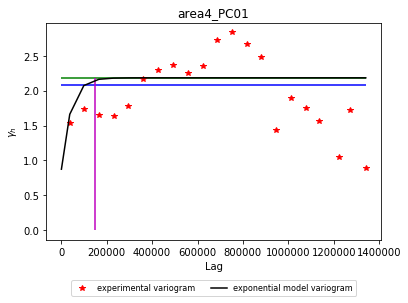

Calculating statistics on variogram model fit...
PC02
Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'exponential' Variogram Model
Partial Sill: 0.528483134967279
Full Sill: 1.320483134967279
Range: 120000
Nugget: 0.792 



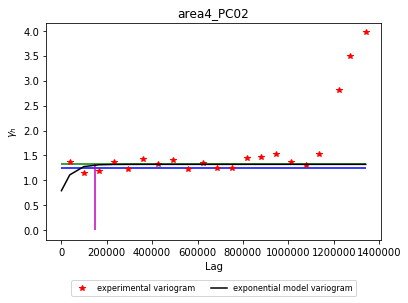

Calculating statistics on variogram model fit...
PC03
Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'exponential' Variogram Model
Partial Sill: 0.6169659043599938
Full Sill: 1.0279659043599938
Range: 120000
Nugget: 0.411 



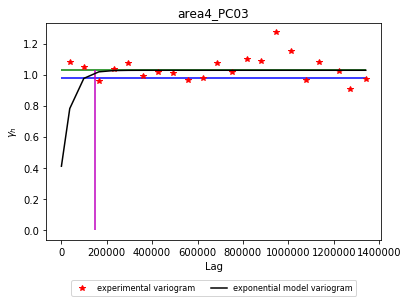

Calculating statistics on variogram model fit...
PC04
Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'exponential' Variogram Model
Partial Sill: 0.18368276033987813
Full Sill: 0.6116827603398781
Range: 120000
Nugget: 0.428 



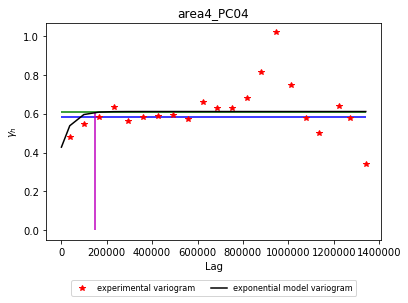

Calculating statistics on variogram model fit...
PC05
Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'exponential' Variogram Model
Partial Sill: 0.08559696260450628
Full Sill: 0.4285969626045063
Range: 120000
Nugget: 0.343 



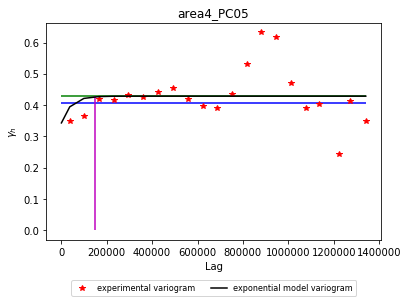

Calculating statistics on variogram model fit...
PC06
Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'exponential' Variogram Model
Partial Sill: 0.11144590313794633
Full Sill: 0.37144590313794634
Range: 120000
Nugget: 0.26 



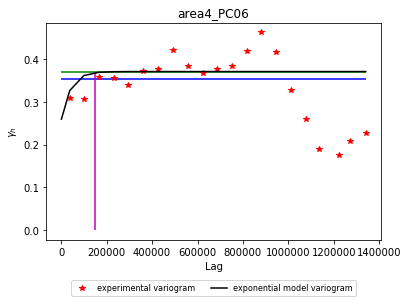

Calculating statistics on variogram model fit...
PC07
Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'exponential' Variogram Model
Partial Sill: 0.022423687723755165
Full Sill: 0.22642368772375515
Range: 120000
Nugget: 0.204 



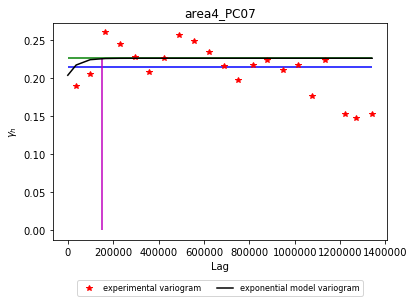

Calculating statistics on variogram model fit...
PC08
Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'exponential' Variogram Model
Partial Sill: 0.06419519992297604
Full Sill: 0.16049519992297603
Range: 120000
Nugget: 0.0963 



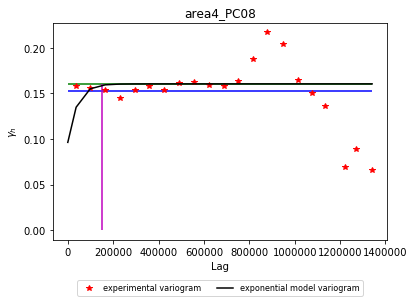

Calculating statistics on variogram model fit...
PC09
Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'exponential' Variogram Model
Partial Sill: 0.02442022365264135
Full Sill: 0.12202022365264135
Range: 120000
Nugget: 0.0976 



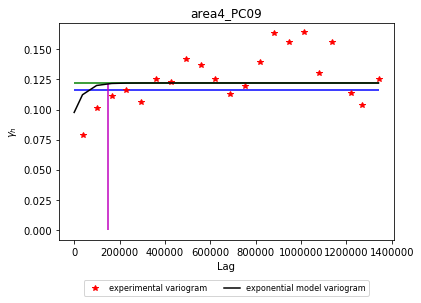

Calculating statistics on variogram model fit...
PC10
Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'exponential' Variogram Model
Partial Sill: 0.10911362412822674
Full Sill: 0.10911362412822674
Range: 100000
Nugget: 0.0 



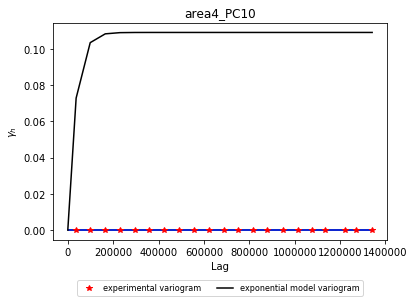

Calculating statistics on variogram model fit...
PC11
Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'exponential' Variogram Model
Partial Sill: 0.02846142116953906
Full Sill: 0.02846142116953906
Range: 100000
Nugget: 0.0 



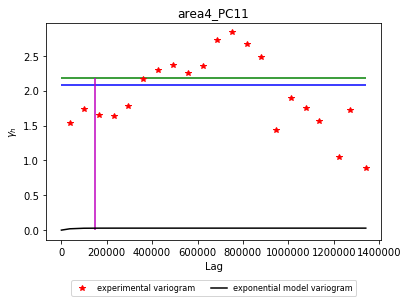

Calculating statistics on variogram model fit...
PC12
Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'exponential' Variogram Model
Partial Sill: 0.006085907332624561
Full Sill: 0.006085907332624561
Range: 100000
Nugget: 0.0 



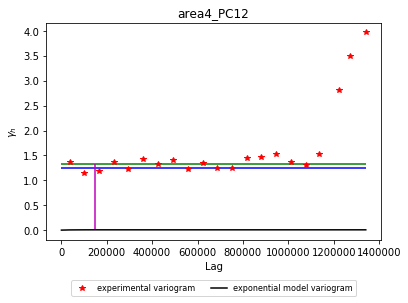

Calculating statistics on variogram model fit...
Wall time: 4.98 s


In [45]:
%%time
# Initialize empty dictionary
variograms = {}

# Loop though the diiferent principal components
for component in mineralogy_pca_df.columns.tolist()[:-1]:
    print(component)
    # Subset principal component to use
    data = mineralogy_pca_df.iloc[:, int(component[-1])-1].values
    variograms[component] = \
        OrdinaryKriging(X, Y, data,
                        variogram_model='exponential',
                        variogram_parameters=variogram_model_parameters[component],
                        nlags=n_lags,
                        verbose=True,
                        enable_statistics=False,
                        enable_plotting=True,
                        weight=True,
                        saveplot=True,
                        coordinates_type='euclidean',
                        saveloc="../_FIGURES/variograms/",
                        principal_component=component,
                        pluton=group_name,
                        show_nlag_pairs=False, # Turn off displaying number of lag pairs in lag bin
                        show_range_determine_guide=True, # 0.95 * sill highlighted with blue line to help determining range
                        range_estimate=150000) # Pass in value in meters to display a line at range estimate; set value to None to not display line
    
# NOTE that ideally Q1 is close to zero, Q2 is close to 1, and cR is as small as possible.

## Leave One Out Cross Validation (LOOCV) of PCA
____

In [46]:
# If you have run the cross validation before you can load the results by
# running this cell and don't have to run the next cell anymore.
CV_results = preproc.load_obj("CV_results_fast")

**The error below should be fixed now. --> Confirmed, but other error due to NaN values? --> Actual error is also related to linalg error from above**

**The cv_param°dict has been rewritten so that the parameters can be set for each PC.  
Was not sure about the numbers of PCs that you are going to use so I quickly created a loop since the parameters you use aree the same over all PCs (except for variogram_model_parameters).**

**Also made a small change in the function that gets called.  
Basically what happened was that a list was being passed with one item whereas it just expected that one item (without being in a list).  
So just added 'list_name[0]' in the function instead of 'list_name' and all should be good now.**

In [47]:
# Use this cross validation to check the hyper-parameters of your chosen variogram model 
# such as the search_radius, variogram_model, lag_bins etc.

# Cross validation parameter dictionary to use
# You can remove or add options here which will decrease or increase the number 
# of combinations of parameters the cross validation will run
cv_param_dict = {}

for component in mineralogy_pca_df.columns.tolist()[:-1]:
    cv_param_dict[component] = {"method": ["ordinary"],
                                "variogram_model": ["exponential", "spherical"],
                                "variogram_model_parameters": [variogram_model_parameters[component]],
                                "nlags": [n_lags],
                                "weight": [True],
                                "n_closest_points": [number_of_control_points],
                                "search_radius": [range_[0]]
                                }

# The CV function below uses parallel processing to speed things up
# Your CPU will thus reach 100% probably
# To reduce the number of parallel processes to use you can change the following value
# Defaults to -1 to use all available CPU cores; change to number between 1 and 8 e.g. 
# depending on how many cores your CPU has
n_jobs = -1 

In [48]:
%%time
# Run CV and get estimators (using default MSE scorer)

# Instead of running the CV for all the PCs, let's start with only the first 3 
# to get an idea of what are the best parameters to use for the first 3 PCs.
# In a later step we can then obtain the best parameters for all PCs that have 
# a sensible variogram; here this would mean up to and including PC09.
# To specify which PCs to use, you can pass them in as list to the 'components_to_use' variable

# Another change I've made, is that instead of performing leave-one-out-CV 
# where the train set is equal to n_sample - 1 and the test set is equal to 1,
# it makes sense to here use a different strategy, since you're dealing with many more samples.
# Therefore I've included the 'cv_folds' parameter where you can specify 
# the number of train/test groups you want to use during CV
# Let's start with ten groups, which basically means that 
# you use 90% of the samples as train set and 10% as test test
# and this in 10 combinations.

# A a later stage we could change the CV to use a statified cv_fold
# meaning that it ensures for example that for every train/test grouping of the 10 groups
# equal numbers of samples of spcified grouping variable are used 
# (for example your time category or classification later on)

# I've also included the '%%time' statement at the beginning of the cell,
# so that at the end of the calculation you can see how much time it took.

# Have a look here if you want some background info on the CV method used:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

estimators = loocv.perform_loocv(mineralogy_pca_df,
                                 coordinates_utm,
                                 cv_param_dict,
                                 n_jobs=n_jobs,
                                 cv_folds=10,
                                 components_to_use=["PC01", "PC02", "PC03"])

PC01
Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  10 out of  20 | elapsed:    3.8s remaining:    3.8s
[Parallel(n_jobs=-1)]: Done  15 out of  20 | elapsed:    3.8s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    4.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    4.1s finished
C:\Users\Sebastian\Anaconda3\envs\main\lib\site-packages\sklearn\model_selection\_search.py:825: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


PC02
Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  10 out of  20 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  15 out of  20 | elapsed:    0.5s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


PC03
Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  10 out of  20 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  15 out of  20 | elapsed:    0.5s remaining:    0.1s


Wall time: 6.01 s


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.8s finished


In [49]:
%%time
# Run CV and get estimators (using default MSE scorer)

# Instead of running the CV for all the PCs, let's start with only the first 3 
# to get an idea of what are the best parameters to use for the first 3 PCs.
# In a later step we can then obtain the best parameters for all PCs that have 
# a sensible variogram; here this would mean up to and including PC09.
# To specify which PCs to use, you can pass them in as list to the 'components_to_use' variable

# Another change I've made, is that instead of performing leave-one-out-CV 
# where the train set is equal to n_sample - 1 and the test set is equal to 1,
# it makes sense to here use a different strategy, since you're dealing with many more samples.
# Therefore I've included the 'cv_folds' parameter where you can specify 
# the number of train/test groups you want to use during CV
# Let's start with ten groups, which basically means that 
# you use 90% of the samples as train set and 10% as test test
# and this in 10 combinations.

# A a later stage we could change the CV to use a statified cv_fold
# meaning that it ensures for example that for every train/test grouping of the 10 groups
# equal numbers of samples of spcified grouping variable are used 
# (for example your time category or classification later on)

# I've also included the '%%time' statement at the beginning of the cell,
# so that at the end of the calculation you can see how much time it took.

# Have a look here if you want some background info on the CV method used:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

estimators = loocv.perform_loocv(mineralogy_pca_df,
                                 coordinates_utm,
                                 cv_param_dict,
                                 n_jobs=n_jobs,
                                 cv_folds=10,
                                 components_to_use=[f"PC0{i}" for i in range(1, 10)])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


PC01
Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  10 out of  20 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  15 out of  20 | elapsed:    0.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


PC02
Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  10 out of  20 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  15 out of  20 | elapsed:    0.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


PC03
Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  10 out of  20 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  15 out of  20 | elapsed:    0.5s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


PC04
Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  10 out of  20 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  15 out of  20 | elapsed:    0.5s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


PC05
Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  10 out of  20 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  15 out of  20 | elapsed:    0.5s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


PC06
Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  10 out of  20 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  15 out of  20 | elapsed:    0.5s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


PC07
Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  10 out of  20 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  15 out of  20 | elapsed:    0.5s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


PC08
Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  10 out of  20 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  15 out of  20 | elapsed:    0.5s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


PC09
Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  10 out of  20 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  15 out of  20 | elapsed:    0.5s remaining:    0.1s


Wall time: 7.74 s


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.7s finished


In [50]:
# Convert estimators to dict of dataframes
CV_results = loocv.convert_scores_to_df(estimators)

In [51]:
# Save CV_results to pickle file for easy use later
# These are the results from the 56min CV above (with only first 3 PCs)
preproc.save_obj(CV_results, "CV_results_summarized")

In [52]:
# Save CV_results to pickle file for easy use later
# These are the results from the 2min CV above (with only first 9 PCs, simple parameters)
preproc.save_obj(CV_results, "CV_results_fast")

In [53]:
# Quick look at best results per PC
loocv.print_best_scores(CV_results)

PC01
rank_test_score                    2
mean_test_score              1.59618
std_test_score              0.552598
mean_train_score         3.25457e-31
param_method                ordinary
param_variogram_model    exponential
param_search_radius           120000
Name: 0, dtype: object


PC02
rank_test_score                    2
mean_test_score              1.18586
std_test_score              0.300552
mean_train_score         1.05169e-31
param_method                ordinary
param_variogram_model    exponential
param_search_radius           120000
Name: 0, dtype: object


PC03
rank_test_score                    2
mean_test_score             0.921695
std_test_score              0.241796
mean_train_score                   0
param_method                ordinary
param_variogram_model    exponential
param_search_radius           120000
Name: 0, dtype: object


PC04
rank_test_score                  2
mean_test_score           0.499032
std_test_score            0.184583
mean_train_score       

## Calculating predictions for best model
____

In [54]:
# Here you can specify the components and search_radii you want to use 
# when performing the kriging and performing the postprocessing calculations
components_to_use = [f"PC0{i}" for i in range(1, 10)]
search_radii = [range_[0]]

In [55]:
estimators_final = {}

for component in components_to_use:  # Changed to only first 9 PCs
    for radius in search_radii:  # Removed critical_distance
        for variable_to_fit in ["estimates", "variances"]:

            estimators_final[f"{component}_{radius}_{variable_to_fit}"] = \
                Krige(method='ordinary',
                      variogram_model=variogram_model,
                      variogram_model_parameters=variogram_model_parameters[component],
                      nlags=n_lags,
                      weight=True,
                      n_closest_points=number_of_control_points,
                      search_radius=radius,
                      variable_to_fit=variable_to_fit)

In [56]:
# Run this cell if you have previously run the next cell and saved its outcome
kriging_predictions = preproc.load_obj("kriging_predictions")

In [57]:
%%time
# You can again change the n_jobs to lower the #CPU cores used for parallel processing
# Also set the cv_folds variable below
cv_folds = 10

kriging_predictions = {}

for component in components_to_use:  # Changed to only first 9 PCs
    for radius in search_radii:  # Removed critical_distance
        for variable_to_fit in ["estimates", "variances"]:
            
            # Let's print out the combination to see where we are in the loops
            print(component, radius, variable_to_fit)
            
            kriging_predictions[f"{component}_{radius}_{variable_to_fit}"] = \
                cross_val_predict(estimators_final[f"{component}_{radius}_{variable_to_fit}"], 
                                  X=np.stack((coordinates_utm["X"],
                                              coordinates_utm["Y"]), axis=1),
                                  y=mineralogy_pca_df[component],
                                  cv=cv_folds,
                                  n_jobs=-1,
                                  verbose=5)

PC01 120000 estimates
PC01 120000 variances


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.0s r

PC02 120000 estimates
PC02 120000 variances


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


PC03 120000 estimates
PC03 120000 variances


[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0

PC04 120000 estimates
PC04 120000 variances


[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s


PC05 120000 estimates
PC05 120000 variances


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


PC06 120000 estimates
PC06 120000 variances


[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0

PC07 120000 estimates
PC07 120000 variances


[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished


PC08 120000 estimates
PC08 120000 variances


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


PC09 120000 estimates
PC09 120000 variances


[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished


Wall time: 2.69 s


In [58]:
preproc.save_obj(kriging_predictions, "kriging_predictions")

## Calculate clr solutions
____

In [59]:
kriging_estimates_df = {}

for radius in search_radii:
    temp = {}
    
    for component in components_to_use:
        key = f"{component}_{radius}_estimates"
        temp[key] = kriging_predictions[key]

    kriging_estimates_df[f"{radius}"] = pd.DataFrame.from_dict(temp)
    kriging_estimates_df[f"{radius}"].index = mineralogy_pca_df.index
    kriging_estimates_df[f"{radius}"].columns = components_to_use
    
    print(f"{radius}")
    kriging_estimates_df[f"{radius}"].head()

120000


,PC01,PC02,PC03,PC04,PC05,PC06,PC07,PC08,PC09
5,0.458841,0.622140,0.025826,-0.202215,0.134933,0.101988,-0.056761,0.202294,-0.004651
21,-0.546156,0.808279,0.749267,0.708861,-0.668001,-0.618144,0.332375,0.114501,0.133501
29,-0.312890,1.046587,1.251889,0.859232,-0.993711,-0.254703,0.177054,-0.268381,0.417320
53,0.376529,-0.492875,0.018498,0.260302,-0.011085,-0.126087,-0.313524,0.068842,0.050111
62,-0.334344,-0.426154,-0.189285,-0.356700,-0.165762,-0.081109,-0.304778,0.066048,-0.037304


In [60]:
kriging_variances_df = {}


for radius in search_radii:
    temp = {}
    
    for component in components_to_use:
        key = f"{component}_{radius}_variances"
        temp[key] = kriging_predictions[key]
        
    kriging_variances_df[f"{radius}"] = pd.DataFrame.from_dict(temp)
    kriging_variances_df[f"{radius}"].index = mineralogy_pca_df.index
    kriging_variances_df[f"{radius}"].columns = components_to_use
    
    print(f"{radius}")
    kriging_variances_df[f"{radius}"].head()

120000


,PC01,PC02,PC03,PC04,PC05,PC06,PC07,PC08,PC09
5,1.317065,1.052773,0.618754,0.535081,0.402818,0.324998,0.224478,0.127989,0.114651
21,1.157569,0.966115,0.543803,0.505746,0.393544,0.307205,0.227464,0.117461,0.111995
29,1.325573,1.025655,0.622817,0.522920,0.397678,0.317617,0.225047,0.124692,0.113182
53,1.303041,1.012524,0.612224,0.516169,0.391780,0.313516,0.220639,0.123096,0.111505
62,2.002837,1.277984,0.941333,0.604845,0.431138,0.367312,0.230483,0.155338,0.122736


In [61]:
kriging_variances_mean_df = {}

for radius in search_radii:
    kriging_variances_mean_df[f"{radius}"] = \
        kriging_variances_df[f"{radius}"].mean(axis=0)

    print(f"{radius}")
    kriging_variances_mean_df[f"{radius}"]

120000


PC01    1.500313
PC02    1.100094
PC03    0.704983
PC04    0.549640
PC05    0.410661
PC06    0.333830
PC07    0.228642
PC08    0.133735
PC09    0.116886
dtype: float64

In [62]:
kriging_estimates_clr = {}

for ncomp in range(1, len(components_to_use) + 1):
    for radius in search_radii:

        kriging_estimates_clr[f"{ncomp}_{radius}"] = \
            postproc.reverse_pca(mineralogy_pca, 
                                 kriging_estimates_df[f"{radius}"],
                                 mineralogy_clr,
                                 n_comp=ncomp)

In [63]:
solutions_clr = {}

for ncomp in range(1, len(components_to_use) + 1):
    for radius in search_radii:

        solutions_clr[f"{ncomp}_{radius}"] = \
            pd.DataFrame(kriging_estimates_clr[f"{ncomp}_{radius}"], 
                         index=mineralogy_clr.index, 
                         columns=mineralogy_clr.columns)

In [64]:
residuals_clr = {}

for ncomp in range(1, len(components_to_use) + 1):
    for radius in search_radii:

        residuals_clr[f"{ncomp}_{radius}"] = \
            mineralogy_clr.subtract(solutions_clr[f"{ncomp}_{radius}"])

In [65]:
for ncomp in range(1, len(components_to_use) + 1):
    for radius in search_radii:
        temp = pd.merge(residuals_clr[f"{ncomp}_{radius}"], 
                        pd.DataFrame(nvalues_control_points[radius], 
                                     columns=["n_closest_points"]), 
                        left_index=True, 
                        right_index=True)\
                 .sort_values("n_closest_points")
        
        temp.to_excel(f"../_RESULTS/Residuals/residuals_clr_{ncomp}_{radius}_{group_name}.xlsx")

In [66]:
preproc.save_obj(residuals_clr, "residuals_clr")

In [67]:
preproc.save_obj(nvalues_control_points, "nvalues_control_points")

## Error budget
____

In [68]:
# A = mean squared prediction error
# B = nugget
# C = non-explained variance of model
error_budget = {}

for radius in search_radii:
    for ncomp in range(1, len(components_to_use) + 1):
        A = np.mean(np.sum(residuals_clr[f"{ncomp}_{radius}"] ** 2, axis=1), axis=0)
        B = np.array(nugget_)[:ncomp].sum()
        C = A - B

        error_budget[f"{ncomp}_{radius}"] = [A, B, C]

In [69]:
error_budget_df = \
    ttest.convert_summary_test_results_to_df(error_budget, 
                                             variable_names=["MSPE", 
                                                             "Nugget", 
                                                             "Non-expl var of model"], 
                                             order=["search_radius", 
                                                    "#PCs"])
error_budget_df

,search_radius,#PCs,MSPE,Nugget,Non-expl var of model
0,120000,1,5.999570,0.8750,5.124570
1,120000,2,5.867811,1.6670,4.200811
2,120000,3,5.762773,2.0780,3.684773
3,120000,4,5.652761,2.5060,3.146761
4,120000,5,5.576619,2.8490,2.727619
5,120000,6,5.545214,3.1090,2.436214
6,120000,7,5.528236,3.3130,2.215236
7,120000,8,5.523570,3.4093,2.114270
8,120000,9,5.519171,3.5069,2.012271


In [70]:
error_budget_df.to_excel(f"../_RESULTS/Error_budget/error_budget_{group_name}.xlsx")

## Contour plots
____

In [71]:
nvalues_critical_distance = \
    variograms["PC01"].determine_mask_array(grid[0], 
                                            grid[1], 
                                            search_radius=critical_distance)
mask_critical_distance = nvalues_critical_distance < 3
mask_critical_distance.shape

(476, 2)
(123109, 2)
301 409


(409, 301)

In [72]:
mask_critical_distance[mask_critical_distance == 1].sum()

79955

In [73]:
non_masked_grid_nodes = \
    grid[0].shape[0] * grid[1].shape[0] \
    - mask_critical_distance[mask_critical_distance == 1].sum()

In [74]:
grid_cell_spacing = grid[0][1] - grid[0][0]
grid_cell_area = grid_cell_spacing ** 2

In [75]:
# Pluton area in m²
pluton_area_m2 = non_masked_grid_nodes * grid_cell_area

# Pluton area in km²
pluton_area_km2 = pluton_area_m2 / 1_000_000

In [76]:
pluton_area_km2

562645.0215318123

____

In [77]:
interpolated_dict = preproc.load_obj("interpolated_dict")

In [78]:
# Since my desktop (with 32GB of RAM) ran out of memory,
# I've reduced the grid spacing so that there are fewer grid points 
# to perform the interpolation for

# You could also reduce the number of active CPU cores by decreasing 'n_jobs'
# which would reduce memory consumption
# so that you could still get a more detailed interpolation grid.
# The interpolation will take a bit longer than since 
# not the maximum number of 'workers' can be used in that case.

In [79]:
%%time
interpolated_parallel = Parallel(n_jobs=-6)(delayed(
    OK_model.execute)('masked', 
                     grid[0], 
                     grid[1],
                     mask_critical_distance,
                     n_closest_points=number_of_control_points, 
                     search_radius=range_[0], 
                     backend='loop') for component, OK_model in variograms.items())

Wall time: 57.5 s


In [80]:
interpolated_dict = {}
for i, item in enumerate(interpolated_parallel, start=1):
    interpolated_dict[f"PC0{i}"] = item

In [81]:
preproc.save_obj(interpolated_dict, "interpolated_dict")

In [82]:
# Number of PCs to use for reverse calculations
# Set this variable based on the number of PCs to use to obtain the lowest MSPE value in 1.10 Error budget
n_comp = 3

interpolated_array = postproc.convert_grid_to_array_of_scores(interpolated_dict)

interpolated_reverse_pca = postproc.reverse_pca(mineralogy_pca, 
                                                interpolated_array, 
                                                mineralogy_clr, 
                                                n_comp=n_comp)

interpolated_reverse_clr = postproc.reverse_clr(interpolated_reverse_pca, 
                                                mineralogy_clr)

# You will get a FutureWarning here, that's fine

1
2
3
4
5
6
7
8
9
10
11
12
(12, 409, 301)


C:\Users\Sebastian\Anaconda3\envs\main\lib\site-packages\IPython\core\interactiveshell.py:3331: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [83]:
# Check if the number of points based on the specified grid is equal to
# the sum of the number of masked points and the number of interpolated points
assert grid[0].shape[0] * grid[1].shape[0] == np.sum(np.isclose(interpolated_reverse_clr.sum(axis=1), 0.0)) + \
                                              np.sum(np.isclose(interpolated_reverse_clr.sum(axis=1), 100.0))

In [84]:
interpolated_modal = {}
for mineral in interpolated_reverse_clr.columns.tolist():
    interpolated_modal[mineral] = np.reshape(interpolated_reverse_clr.loc[:, mineral].values, 
                                             (grid[1].shape[0], grid[0].shape[0]))

In [85]:
# If you get an error related to an non-esixting save location
# Please first create a folder on your pc with the same name that 
# you used for the variable 'group_name'

for mineral, interpolation in interpolated_modal.items(): 
    for variable in ["estimates"]:
        print(interpolation.shape)
        plots.plot_contour_map(interpolation,
                               grid,
                               coordinates_utm,
                               group_name,
                               variable=variable,
                               title=f"{mineral} radius={range_[0]}m {variable} masked {critical_distance}m",
                               show_plot=False,
                               single_mineral=True,
                               mineral=mineral,                               
                               label_pos = (0.03, 0.94),
                               skip_xaxis_label=2,
                               skip_yaxis_label=2,
                               skip_xaxis_start=1,
                               skip_yaxis_start=1,
                               marker_symbol='.',
                               marker_size=0.1,
                               marker_color='r',)
        
# Added some options to function so that yu can easily change the appearance 
# of the markers used to show the position of the control points

(409, 301)
SiO2
(409, 301)
TiO2
(409, 301)
Al2O3
(409, 301)
Fe2O3
(409, 301)
FeO
(409, 301)
MnO
(409, 301)
MgO
(409, 301)
CaO
(409, 301)
Na2O
(409, 301)
K2O
(409, 301)
P2O5
(409, 301)
l.i.
(409, 301)
oth


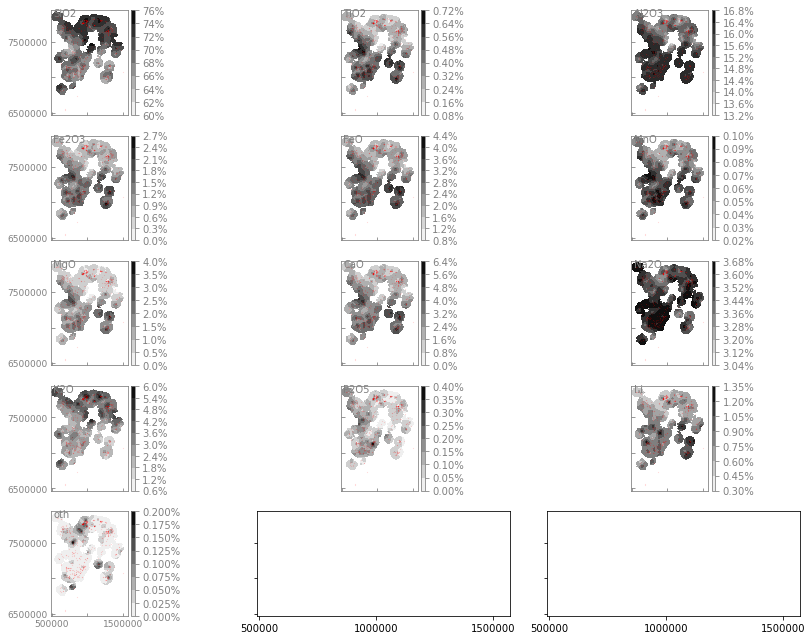

In [86]:
# Specify how many rows and columns you want to use in the following figure
# This will ofcourse depend an the number of variables you would like to plot
# You can also set the figure size
n_cols = 3
n_rows = 5

# Figure with single mineral maps as subplots
plots.plot_contour_map_all(interpolated_modal,
                           grid,
                           coordinates_utm,
                           group_name,
                           title=f"radius={range_[0]}m masked {critical_distance}m",
                           show_plot=True,
                           label_pos = (0.03, 0.94),
                           skip_xaxis_label=2,
                           skip_yaxis_label=2,
                           skip_xaxis_start=1,
                           skip_yaxis_start=1,
                           marker_size=0.1,
                           marker_color='r',
                           marker_symbol='.',
                           figsize=(12, 9),
                           ncols=n_cols,
                           nrows=n_rows,
                           sharex=True,
                           sharey=True)

## Biplots
____

Not relevant for now

## Simulations
____

Not relevant for now